# <font color='red'>STOCK MARKET IS VERY RISKY UNTIL YOU DO IT PROPERLY. PLEASE DO NOT TAKE TRADES JUST BECAUSE THIS TOOL GIVES YOU THE NAME. APPLY YOUR OWN LEARNINGS, CREATE YOUR OWN STRATEGY, ASSESS RISK & TRADE THE PLAN.</font>

# Imports, Defaults and Initializations
Clicking on the below cell is mandatory. Click on the cell below and press `Shift + Enter`. To run any cell, use the same keyboard shortcut.

In [239]:
# import backtrader
from helpers.datahandler import *
from helpers.investing import *
from helpers.journal_handler import *
from helpers.intraday import *
from helpers.nse_data import *
from helpers.backtest import *
from helpers.FnO import analyse_open_interest, get_next_expiry_date
from helpers.online_brokers import KiteZerodha # Yes! Finally we can have live Data for Free!!!
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In = Investing(check_fresh = False, force_update = False) # Investing or Swing trading analysis
Intra = IntraDay() # Intraday strategies and analysis
NSE = NSEData() # Get NSE Live data
MS = MarketSentiment() # Get Live Market Sentiment TICK, TRIN and 52W high/ low stocks
BT = Backtest()
ISS  = IntradayStockSelection() # Few of the Intraday Stock Selection methods. Not methods, but just a few things like stats of Move, Range etc

# In.update_new_listings() # Good to run once in a while say after every 1 month
# In.update_fresh_nifty_indices()
# In.update_FnO() # Future and Options List

# [Journal](https://drive.google.com/file/d/1JipUU6Im1YVKSdufw4VHitwS010nFigL/view)
Make a journal in Google Drive for each trade you take to analyse. **It is a not so simple process and need to connect with Google API so if you're not comfortable with it, just skip it**

In [2]:
private_key = join(expanduser('~'),'Documents','client_secret.json') # Personal for each user. Mine is stored in /home/Documents
JH = JournalHandler(private_key)

journal = JH.get_journal('Finance Journal') # My Google Sheet jornam has name "Finance Journal"

JH.total_pl(journal) # total Profit and Loss up until now

--------------------------------------------------------------------------- 

--------------------------------------------------------------------------- 



-1693.15

# [Swing  Trading Strategies](https://www.investopedia.com/terms/s/swingtrading.asp)
## Tweak parameters by reading the Docstring
## Basic Details
Basic Details about stocks such as Momentum, Ichimoku, 1-2-3 candles pattern etc

In [ ]:
budget = 400000

df = In.get_recent_info(nifty = 500, **{'mvs':[20,50,100,200]})
df.head(2) # show first 2 values

## Breakout
Stocks that might breakout. Includes only those stocks which are above 50 days SMA, have atleast `n` number of touches within the `p%` of the recent candle. Just look at these stocks manually. Change the parameters to control the number of stocks to scan.

In [ ]:
In.tight_consolidation_stocks(stocks = 'nifty_500', diff = 0.007, min_count = 5, lookback_period = 10) # There should be atleast 5 candles touching the +- 0.75% of the line within 7 days

## 44-SMA 
If you find a `Green` candle taking support on 44 days `Simple Moving Average` line and stock is in uptrend, you can take the trade and set Risk to Reward ratio as 1:2

In [ ]:
budget = 40000 # Total Budget
risk = 400 # Risk per trade
df = In.show_full_stats(budget = budget,risk=risk, diff = 150, nifty='nifty_500') # Show only stocks undder your budget and  whose recent candle's lowest is not more than 151 rupees above the moving average line
df[(df['RSI Value'] < 50) & (df['CCI Value'] < 200)]

## Stocks with 44 SMA in uptrend

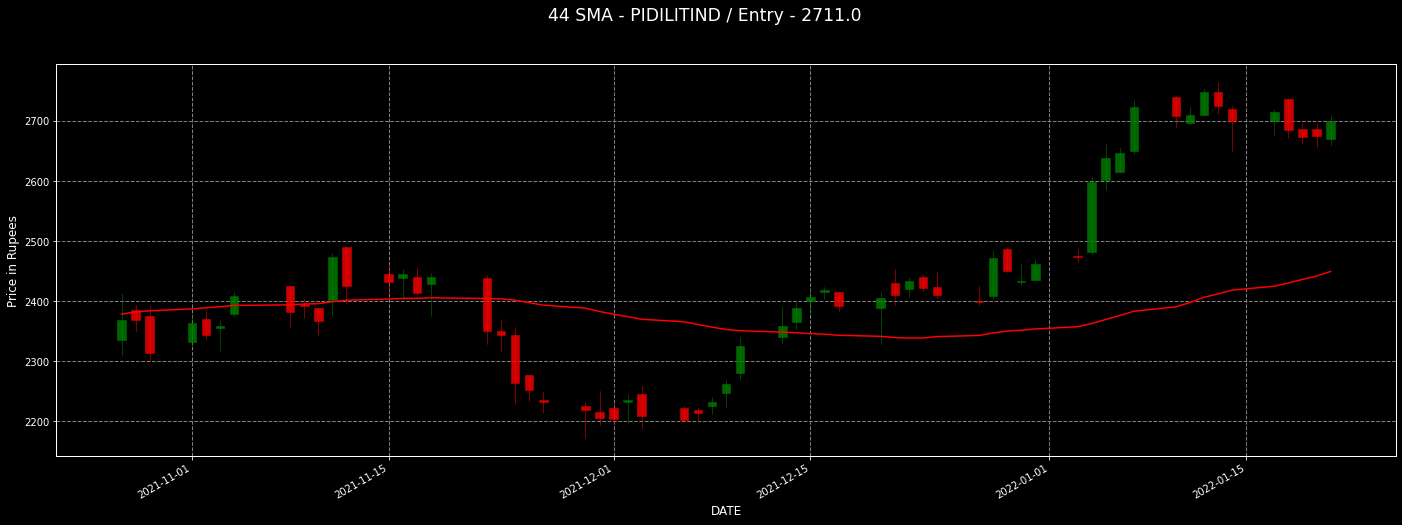

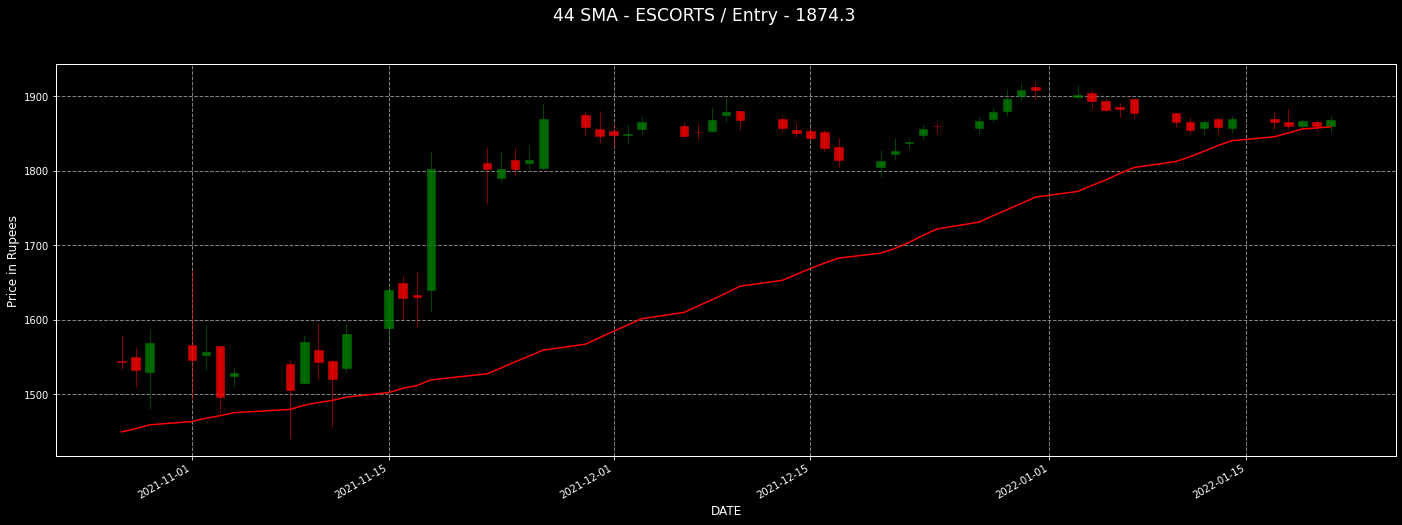

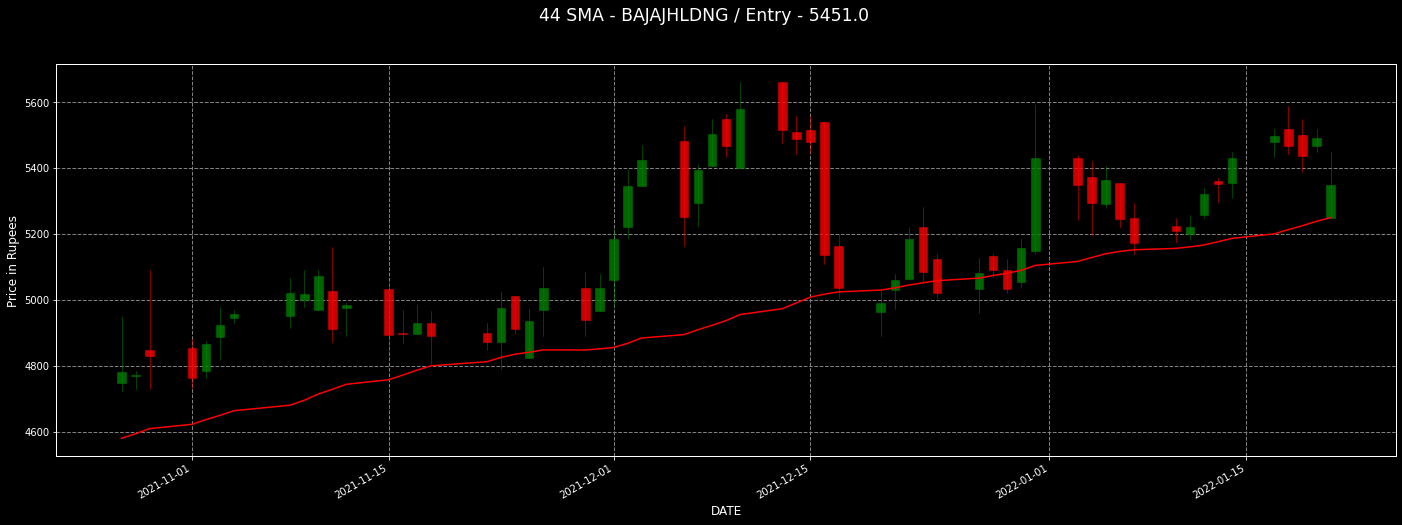

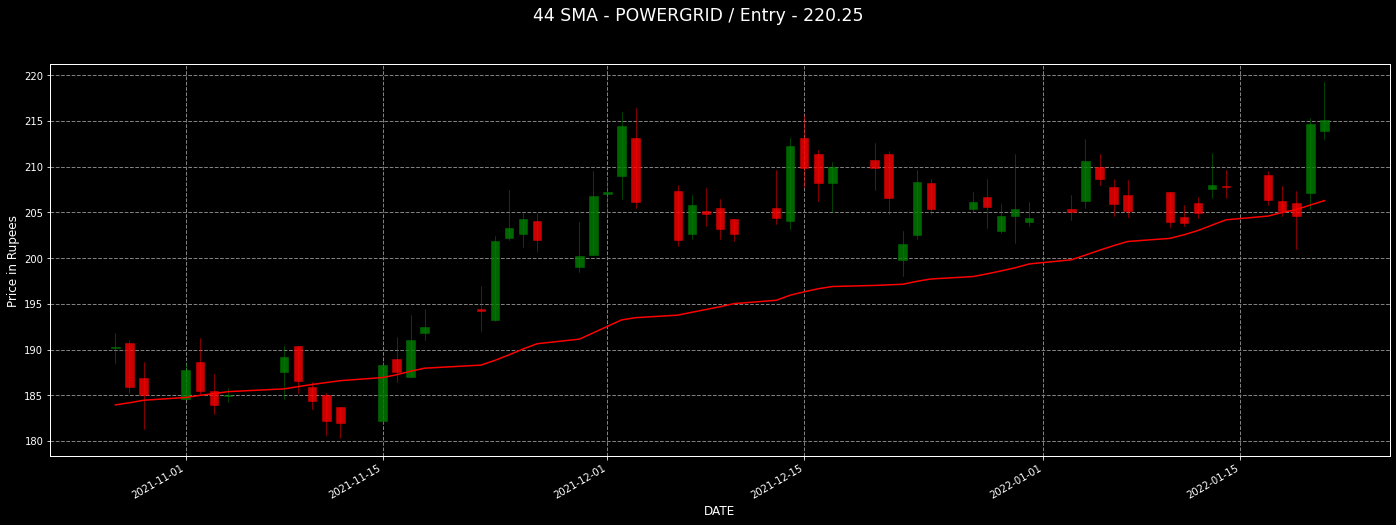

In [313]:
def print44SMAChart(name, stock_selected = None):
    df = In.open_downloaded_stock(name)
    df = df[::-1]
    df['44SMA'] = df['CLOSE'].rolling(window = 44, min_periods = 1).mean()
    df = df.truncate(after=60)
    
    ohlc = df.loc[:, ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE']]
    ohlc['DATE'] = pd.to_datetime(ohlc['DATE'])
    ohlc['DATE'] = ohlc['DATE'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    fig, ax = plt.subplots()
    
    graph_title = '44 SMA - ' + name
    # If stock_selected is provided, show entry, target, stop loss values
    if stock_selected is not None:
        graph_title = graph_title + ' | ENTRY - ' + str(stock_selected['ENTRY'])
        graph_title = graph_title + ' | SL - ' + str(stock_selected['SL'])
    fig.suptitle(graph_title, size='xx-large')
    candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    
    df = df.set_index('DATE')
    df['44SMA'].plot(figsize = (24, 8), color="red")
    plt.style.use("dark_background")
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.ylabel("Price in Rupees")
    plt.show()

def isStockInUptrend(name, check_green_candle_support = False):
    df = In.open_downloaded_stock(name)
    df = df[::-1]
    df['44SMA'] = df['CLOSE'].rolling(window = 44, min_periods = 1).mean()
    df = df.truncate(after=60)
    # Get max value
    max = df['44SMA'].max()
    last = df['44SMA'].iloc[-1]
    stock_selected = None
    if max == last:
        stock_selected = df.iloc[-1].copy()
        if check_green_candle_support:
            # Check if green candle is taking support on 44 SMA
            open_price = df['OPEN'].iloc[-1]
            close_price = df['CLOSE'].iloc[-1]
            green_candle_support = close_price > open_price and open_price > last
            if green_candle_support:
                stock_selected['ENTRY'] = stock_selected['HIGH'] + 1
                
                low_of_last_candle = df['LOW'].iloc[-1]
                low_of_second_last_candle = df['LOW'].iloc[-2]
                sl = low_of_last_candle if low_of_last_candle < low_of_second_last_candle else low_of_second_last_candle
                stock_selected['SL'] = sl -1
            else:
                stock_selected = None
            
    return stock_selected

# isStockInUptrend('POWERGRID')
# print44SMAChart('POWERGRID')

for name in In.data['nifty_200']:
    stock_selected = isStockInUptrend(name, check_green_candle_support = True)
    if stock_selected is not None:
        print44SMAChart(name, stock_selected)
        print('\n\n')

# with pd.option_context('display.max_rows', 10, 'display.max_columns', 5):
#     print(df)

## Golden Crossover
When 44 days `SMA` Crosses 200 days `SMA` from below and you find a `Green` candle within 15 days taking support on `44` days line set Risk to Reward ratio as 1:5

In [8]:
for name in In.data['nifty_200']:
    df = In.open_downloaded_stock(name)
    if In.has_golden_crossover(df,lookback=21):
        print(name)

YESBANK
SYNGENE
POWERGRID
DIXON
VBL
UPL
ABCAPITAL


## RSI Signal: Oversold / Overbought Stocks
Buy when RSI is less than 30 sell when greater than 70

In [8]:
for name in In.data['nifty_500']:
    df = In.open_downloaded_stock(name)
    if In.get_RSI(df,signal_only=True) == "Buy":
        print(name)

APOLLOHOSP


## MACD Signal
It is the strategy when MACD (Blue) Line cuts the Signal (Red) line from below then it is a buy signal. When the blue line cuts from upside down, it is sell signal

In [9]:
for name in In.data['nifty_50']:
    df = In.open_downloaded_stock(name)
    if In.macd_signal(df) == 'Buy':
        print(name)

POWERGRID


## CCI Signal : Rally
**Faster than MACD Signal works closely with Stochastic RSI**

When CCI values comes from below  -100 to above -100, buy signal and when it comes from above +100 to below +100, sell signal

In [14]:
for name in In.data['nifty_500']:
    df = In.open_downloaded_stock(name)
    if In.get_CCI(df, signal_only = True) == 'Buy':
        print((name, In.get_index(name)))

('SOLARINDS', 'Nifty 500')
('EPL', 'Nifty 500')
('DHANI', 'Nifty 200')
('SYNGENE', 'Nifty 200')
('SAIL', 'Nifty 100')
('LAOPALA', 'Nifty 500')
('SRTRANSFIN', 'Nifty 200')
('RATNAMANI', 'Nifty 500')
('POWERGRID', 'Nifty 50')
('SHRIRAMCIT', 'Nifty 500')
('PEL', 'Nifty 100')
('MUTHOOTFIN', 'Nifty 100')
('VGUARD', 'Nifty 500')
('FINEORG', 'Nifty 500')
('NAVINFLUOR', 'Nifty 200')
('GODREJIND', 'Nifty 200')
('GLAXO', 'Nifty 500')


# Stochastic Oscillator
1. Buy when the fast line cuts the slow line from below in an OVERSOLD zone ( both are below 20). Wait for both lines to go above Oversold and then buy. Recent candle closing must be above 200-MA

2. Sell when both lines reaches Overbought region (above 70) and fast line crosses slow from above. Wait for both lines to go below the threshold

In [13]:
for name in In.data['nifty_500']:
    if In.Stochastic(In.open_downloaded_stock(name), signal_only = True) == "Buy":
        print(name, In.get_index(name))

# Intraday 
## See documentations for Intraday strategies

## Pivots Points
As discusses in the book, [How to Make Money in Intraday Trading by Ashwani Gujral](https://www.amazon.in/How-Make-Money-Intraday-Trading/dp/9386268159) (go to `./ebooks` directory to find the annoted version of this book), this one is very important indicator. None of the online screening platforms have support for displaying [`CPR`](https://zerodha.com/varsity/chapter/the-central-pivot-range/) by default and most of these do not even show the Pivots, Support, Resistance until `9:15`. This one gives you the values of `Pivot with CPR, 3 Supports and Resistances` at the day end as long as the NSE updates the day end data so that you can plan your day in advance.

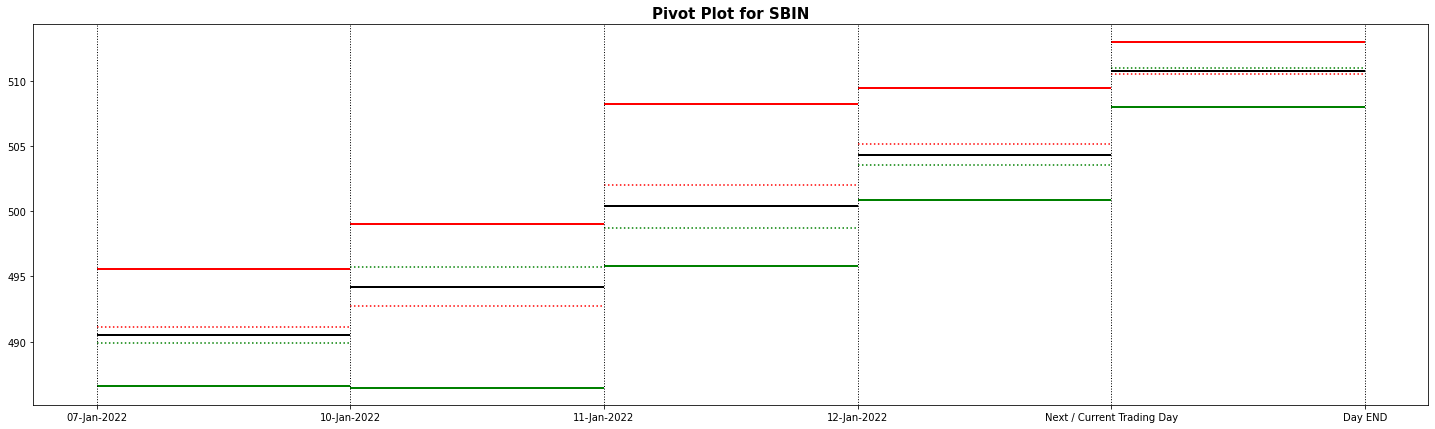

In [2]:
data = In.open_live_stock_data('SBIN')
pivot_data = In.get_Pivot_Points(data, plot = True, num_days_back=5) # access pivot_data to see exact values of support resistances and pivots and pivots boundries

## Narrow Range (Stock Selection)
If recent candle's range is lowest among `X` other days then the future candle might break it's low/high

In [11]:
for name in In.data['nifty_500']:
    if Intra.NR_strategy(name, range_ = 20):
        print(Intra.prob_by_percent_change(symbol = [name], index = None, time_period = 10, change_percent=0.07),In.get_index(name,'all'))

{'SUPPETRO': {'Long Probability': 0.3, 'Short Probability': 1.0}} ['Nifty 500']
{'INDHOTEL': {'Long Probability': 0.6, 'Short Probability': 1.0}} ['Nifty 200']
{'CUB': {'Long Probability': 0.7, 'Short Probability': 0.9}} ['Nifty 200', 'NIFTY PRIVATE BANK']
{'GUJALKALI': {'Long Probability': 0.6, 'Short Probability': 1.0}} ['Nifty 500']
{'ZENSARTECH': {'Long Probability': 0.8, 'Short Probability': 0.8}} ['Nifty 500']
{'ABFRL': {'Long Probability': 0.8, 'Short Probability': 0.9}} ['Nifty 200']
{'GILLETTE': {'Long Probability': 0.3, 'Short Probability': 0.8}} ['Nifty 500']
{'BEML': {'Long Probability': 0.7, 'Short Probability': 0.7}} ['Nifty 500']
{'FLUOROCHEM': {'Long Probability': 0.6, 'Short Probability': 0.8}} ['Nifty 500']
{'CUMMINSIND': {'Long Probability': 0.8, 'Short Probability': 0.6}} ['Nifty 200', 'NIFTY MNC']
{'BIRLACORPN': {'Long Probability': 0.8, 'Short Probability': 0.7}} ['Nifty 500']


## Whole Number Open (Stock Selection + Strategy)
When Open == Low / High in Whole number as `xxx.00` within 15 minutes

In [2]:
Intra.whole_number_strategy(nifty = 100, min_val=101, max_val=5000, print_results = True)

Long :
 Name - Change - ATR - Change% - Remaining Move - Index:

('RELIANCE', 26.0, 64.5, '1.09%', -0.6, 'Nifty 50') 

('GRASIM', 29.9, 50.61, '1.74%', -0.41, 'Nifty 50') 

('NTPC', 2.45, 3.78, '1.96%', -0.35, 'Nifty 50') 

('ADANIGREEN', 66.85, 55.46, '4.82%', 0.21, 'Nifty 100') 

Short :
 Name - Change - ATR - Change% - Remaining Move - Index:

('INDUSTOWER', 3.9, 11.78, '1.44%', -0.67, 'Nifty 100') 

('MUTHOOTFIN', 36.45, 43.24, '2.45%', -0.16, 'Nifty 100') 

('HDFCLIFE', 12.35, 13.99, '1.82%', -0.12, 'Nifty 50') 



## `%` Change probability (Stock Selection)
Gives the stock names which have the highest probability of providing you `x%` in intraday atleast on both long or short side based on the previous `N` days record

In [14]:
# Gives you top 10 stocks from Nifty 500 which have the highest probability of giving atleast 0.99% on your investment based on the Long/Buy position. Data is based on past 60 trading days
# Test it for different time duration, index, % change and Long / Short criteria based on overall market trend
Intra.prob_by_percent_change(symbol = None, index = 200, time_period = 20, change_percent=0.099, sort_by='Long Probability', top_k = 10) 

{'BATAINDIA': {'Long Probability': 0.85, 'Short Probability': 0.5},
 'SONACOMS': {'Long Probability': 0.8, 'Short Probability': 0.45},
 'ADANIENT': {'Long Probability': 0.8, 'Short Probability': 0.4},
 'HAL': {'Long Probability': 0.75, 'Short Probability': 0.6},
 'MCDOWELL-N': {'Long Probability': 0.75, 'Short Probability': 0.5},
 'LTTS': {'Long Probability': 0.75, 'Short Probability': 0.55},
 'LTI': {'Long Probability': 0.75, 'Short Probability': 0.55},
 'GUJGASLTD': {'Long Probability': 0.75, 'Short Probability': 0.7},
 'BHARATFORG': {'Long Probability': 0.75, 'Short Probability': 0.55},
 'FORTIS': {'Long Probability': 0.75, 'Short Probability': 0.7}}

## ATR 
If stock has crossed it's ATR on either side, it might reverse or if it hasn't, there is still a chance to move

In [16]:
df = Intra.ATR_strategy(index = 'NIFTY 200', possible_reversal=False) # if possible_reversal is true, it'll just reverse the order of remaining move %
df.head(20)

,symbol,pChange,open,dayHigh,dayLow,lastPrice,absolute_change,ATR,remaining move %
52,CUMMINSIND,0.13,897.00,901.90,892.20,896.95,0.13,27.016392,-0.82
198,IRCTC,-3.45,898.00,901.70,853.10,862.00,3.45,197.803641,-0.77
78,NAVINFLUOR,-0.33,3508.60,3543.00,3479.20,3505.00,0.33,142.066893,-0.76
41,ESCORTS,0.41,1814.90,1831.00,1796.25,1810.00,0.41,75.096007,-0.75
83,HINDCOPPER,-0.46,120.70,121.65,119.10,119.35,0.46,5.743198,-0.72
70,DIXON,-0.26,5120.00,5147.95,5051.00,5070.75,0.26,230.442496,-0.70
66,ACC,-0.16,2410.00,2428.25,2392.55,2400.00,0.16,61.300714,-0.70
75,SHREECEM,-0.28,26895.00,27000.00,26665.00,26665.00,0.28,714.065296,-0.68
89,SBICARD,-0.60,1008.00,1016.30,998.00,1000.55,0.60,30.732185,-0.67
91,SRTRANSFIN,-0.63,1588.80,1600.95,1570.00,1578.00,0.63,56.132333,-0.67


# [Live Market]()

## Minutes LIVE Data 🤯🤯🤯🤯🤑🤑🤑🤑🥳️🥳️🥳️
Yup! Package now supports `[2,3,4,5,10,15,30,60]` minutes Live Data Too! Finally!!

In order to access the data, there is a unique code associated with every name and is known only to them. You need to write the code for the stock you want to access. This is one time process per stock. You can find that code as follows:

1. Login to `Kite` from your PC and open the chart of `5` minutes for any stock you want to analyse.
2. Click `Ctrl + Shift + I` in Chrome. A new small panel will get opened on the right hand side of screen.
3. Find **NETWORK** in the upper region of that panel. It'll be in the upper region only next to `Elements | Console | Sources | Network`. Click on **NETWORK**
4. Click `CTRL+R` to reload. You'll find something that starts with `5minute?user_id=` under `Name`. [You'll be looking at something like this. Highlighted `holdings` is equal to your `5minute?user_id=`](https://marketsetup.in/posts/zerodha-login/portfolio.png). Click on it and see `Headers` just like in the picture.
5. You'll see a Something like `Request URL: https://kite.zerodha.com/oms/instruments/historical/2513665/5minute?user_id=AB1234&oi=1&from=2022-01-09&to=2022-01-14`
6. The number after `/historical/2513665` is the one you are looking for. So in this case, it is `HAVELLS` code. Save it for future purpose.

### Please help me help you. I am trying to help more and more people. Not everyone can get this code easily and I can not get all the 1600 codes for everyone. If you are looking for a stock and find it's code, just send me a `feature request` or `raise an issue` and paste  the code along with scrip name there so that more and more people can be helped.

In [ ]:
Kite = KiteZerodha(user_id = 'AB1234',password = "password@123",two_factor_pin = 123456) # You'll be logged out from your PC as much as I know
df =  kite.get_historical_minutes_data(name = 'HAVELLS', code = None, interval = 15, starting_from_date = None, no_days_back = 50, get_latest_only = False) # can also directly use code = 2513665
# Get 15 minutes data of HINDPETRO starting from Today (including current candles) to the previous 50 days. If get_latest_only = True, it would give you 1 days day i.e Today
df

## Market Sentiment: TICK, TRIN (Arm's Index) & 52W High-Low touching shares

In [14]:
MS.get_live_sentiment()

Watch out as TICK -45 Bearish and TRIN 0.529 Bullish have opposite sentiments


{'Latest Updated on': '20/01/2022 15:49:59',
 'Up': 788,
 'Down': 833,
 'TICK': -45,
 'Volume Up': 1525.03,
 'Volume Down': 853.6,
 'TRIN': 0.529,
 '52W High': 96,
 '52W Low': 9}

## [Volatility Index: VIX](https://www.motilaloswal.com/blog-details/6-things-that-the-Volatility-Index-(VIX)-indicates-to-you../1929)

In [18]:
NSE.get_VIX()

Current VIX: 17.0950


## MMI: [Market Mood Index](https://www.tickertape.in/market-mood-index)

Please click on the link above to get the values. All credits to [Ticker Tape Website](https://www.tickertape.in/)

In [19]:
get_mmi(raw = True) # True means a simple Json shows current, last week, last month MMI

{'currentValue': 35.087171038762804,
 'date': '2021-11-24T14:20:04.589Z',
 'indicator': 35.087171038762804,
 'lastDay': {'indicator': 33.86992310290614,
  'date': '2021-11-23T00:00:00.000Z',
  'nifty': 17503.35},
 'lastWeek': {'indicator': 49.06614474165184,
  'date': '2021-11-16T00:00:00.000Z',
  'nifty': 17999.2},
 'lastMonth': {'indicator': 49.81882013493076,
  'date': '2021-10-20T00:00:00.000Z',
  'nifty': 18266.6},
 'nifty': 17415.05}

## Current Index Performance
Includes Nifty, Thematic and Sectoral indices and show `Top-N` sorted by change %

In [24]:
NSE.current_indices_status(10) # Live as of market is open. works post market also

,index,percentChange,key,variation
8,INDIA VIX,-5.10,BROAD MARKET INDICES,-0.92
21,NIFTY MEDIA,2.00,SECTORAL INDICES,44.60
48,NIFTY CPSE,1.57,THEMATIC INDICES,36.20
20,NIFTY IT,-1.52,SECTORAL INDICES,-538.15
16,NIFTY AUTO,-1.28,SECTORAL INDICES,-146.85
44,NIFTY ALPHA LOW-VOLATILITY 30,-1.25,STRATEGY INDICES,-215.30
31,NIFTY GROWTH SECTORS 15,-1.12,STRATEGY INDICES,-87.85
43,NIFTY200 QUALITY 30,-1.12,STRATEGY INDICES,-166.50
35,NIFTY50 PR 2X LEVERAGE,-1.02,STRATEGY INDICES,-92.10
34,NIFTY50 TR 2X LEVERAGE,-1.02,STRATEGY INDICES,-125.20


In [25]:
NSE.open_nse_index('NIFTY ENERGY',) # Returns performance of stocks in a given index

,symbol,pChange,open,dayHigh,dayLow,lastPrice,absolute_change
1,ONGC,4.26,149.00,155.85,149.00,152.95,4.26
10,ADANIGREEN,-1.84,1420.00,1429.00,1370.00,1381.10,1.84
9,RELIANCE,-1.77,2380.00,2409.90,2343.55,2343.55,1.77
2,NTPC,1.27,134.50,137.30,133.55,135.20,1.27
3,GAIL,1.16,139.00,143.20,139.00,140.10,1.16
4,BPCL,1.11,401.10,409.30,398.80,402.00,1.11
5,IOC,0.83,126.70,129.30,126.40,127.20,0.83
8,ADANITRANS,-0.74,1916.05,1985.00,1904.00,1940.05,0.74
6,TATAPOWER,0.57,240.00,246.70,237.30,238.30,0.57
7,POWERGRID,0.50,202.20,207.45,202.00,202.85,0.50


In [26]:
In.stock_current_index_performance('HAVELLS') # All the eligible indices (and their current performance) where this stock belongs to. Some stocks might not belong aywhere

,index,percentChange,key,variation
47,NIFTY INDIA CONSUMPTION,-0.76,THEMATIC INDICES,-55.45
2,NIFTY 100,-0.51,BROAD MARKET INDICES,-90.50
28,NIFTY CONSUMER DURABLES,-0.46,SECTORAL INDICES,-131.50


## Stocks trading at their 52W Low / High

In [27]:
NSE.stocks_at_52W(direction = 'low') # set direction = 'high' for stocks going up

,symbol,comapnyName,new52WHL,prev52WHL,prevHLDate,ltp,prevClose,change,pChange
0,AIROLAM,Airo Lam limited,54.15,55.00,23-Nov-2021,56.00,56.05,-0.05,-0.089206
1,DFMFOODS,DFM Foods Limited,282.00,282.60,23-Nov-2021,285.20,291.75,-6.55,-2.245073
2,DSPNEWETF,DSP Mutual Fund - DSP Nifty 50 Equal Weight ETF,195.00,195.00,23-Nov-2021,197.00,196.40,2.53,1.300972
3,FOCUS,Focus Lighting and Fixtures Limited,83.05,0.00,-,85.30,81.25,4.05,4.984615
4,ICICICONSU,ICICI Prudential Mutual Fund - ICICI Prudentia...,58.05,71.10,03-Nov-2021,72.20,72.83,-0.11,-0.152123
5,IHCL-RE,INDIAN HOTELS CO LTD-RE,52.05,0.00,-,54.50,57.25,-2.75,-4.803493
6,MOGSEC,Motilal Oswal Mutual Fund - Motilal Oswal 5 Ye...,45.00,45.00,08-Nov-2021,49.14,49.24,-0.10,-0.203087
7,MOL,Meghmani Organics Limited,81.10,83.90,23-Nov-2021,81.10,84.50,-3.40,-4.023669
8,NXTDIG-RE,NXTDIGITAL LIMITED-RE,31.90,48.10,22-Nov-2021,31.90,53.10,-21.20,-39.924670
9,SIGACHI,Sigachi Industries Limited,486.35,511.90,23-Nov-2021,537.45,511.90,25.55,4.991209


# Futures and Options

## [Analyse Option Chain](https://www.quora.com/How-do-I-read-analyse-the-option-chain-of-a-stock-to-intraday-trade-with-clarity-NSE). Very helpful

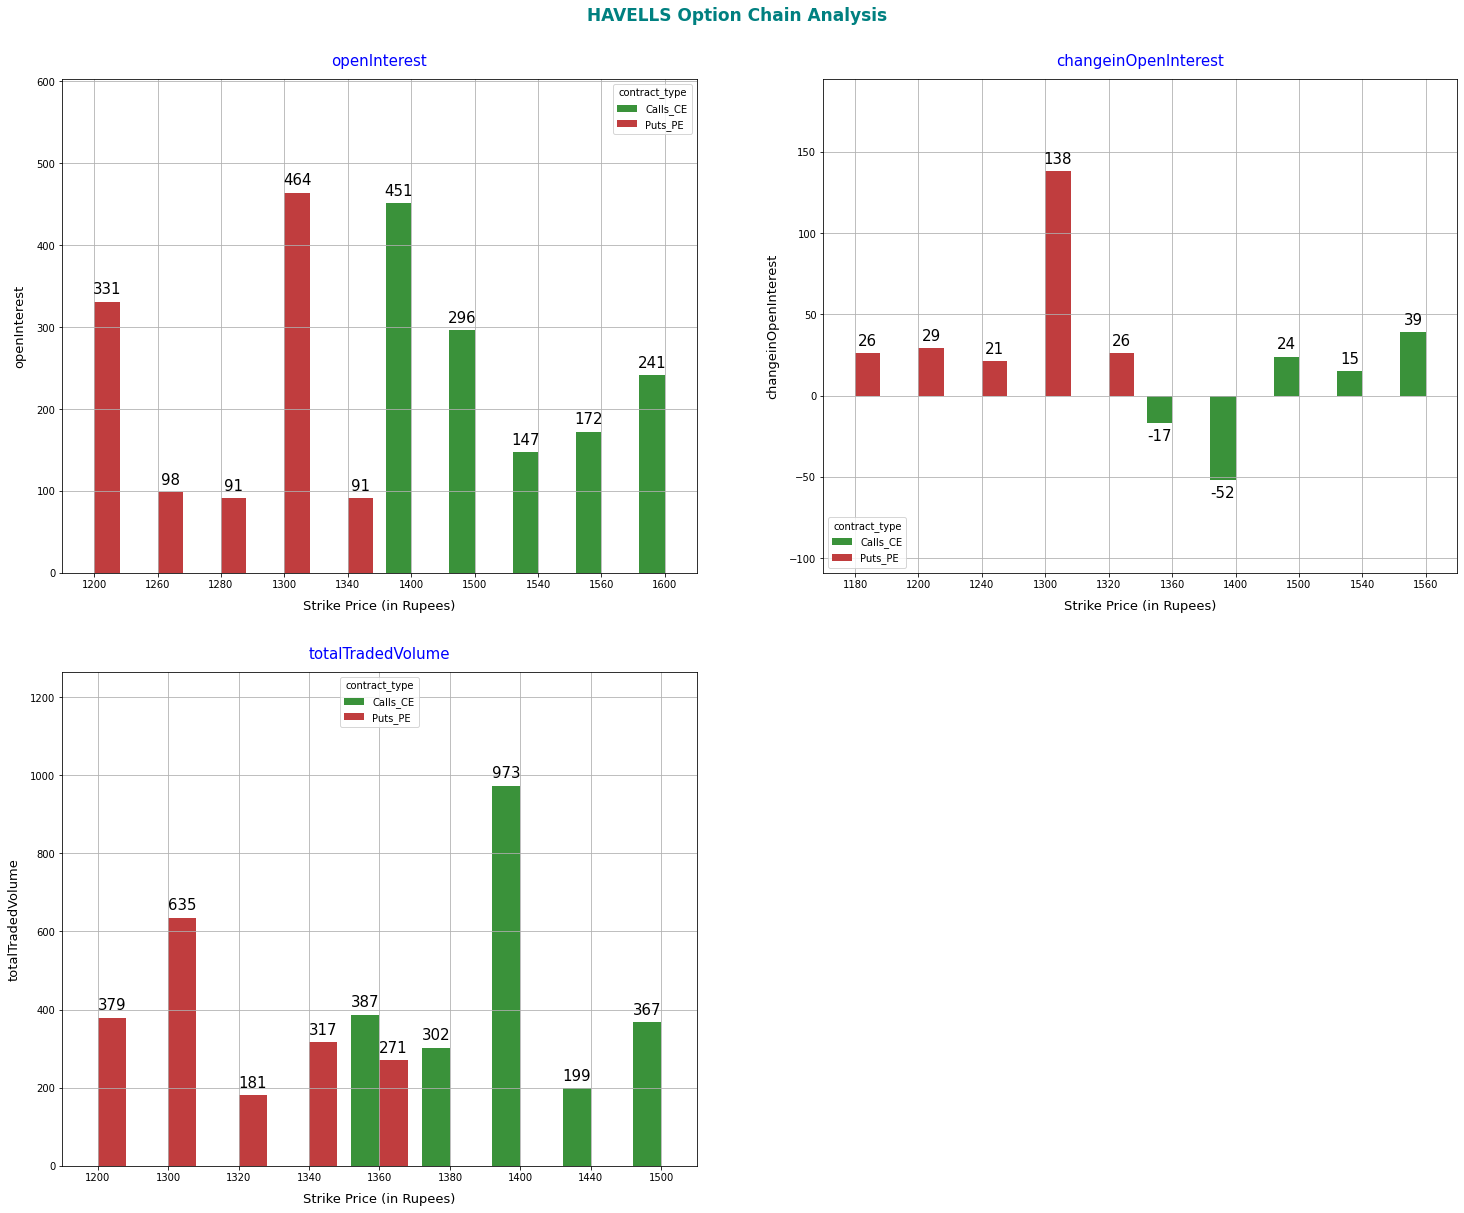

In [2]:
filtered_df = analyse_open_interest('HAVELLS',expiry_dates=['30-Dec-2021'],) # Read the Doc String. Manually compare other parameters such as openInterest

# [Back Testing](https://www.investopedia.com/terms/b/backtesting.asp)
## Back Testing Stratagies to get the best Win %, Max Return Investment etc
Pass in the parameters dict for all. Check Docstring of each individual function for how a strategy works in buying or selling.

## CCI
`BT.backtest('cci', stocks=['DIVISLAB'])` , for individual stock data performance to tell how much a stock would have gained or lost

In [34]:
cci_parameters = {'buying_thresh':-100, 'selling_thresh':100, 'window':20, 'cols':('OPEN','CLOSE','LOW','HIGH', 'DATE')} # check documentation of BT.cci()

# Using the CCI strategy, Return top gaining stocks which have traded atleast 365 recent days and are currently in nifty-500
BT.backtest('cci', min_days = 365, top_n=10, stocks = 'nifty_500', **cci_parameters)

,win%,wins,losses,ROI,p&l,buy_date,sell_date,buy_price,sell_price,hold_period,buys,sells,days
ALEMBICLTD,1.0,7,0,5.85,"[15.299999999999997, 0.9500000000000028, 4.049...","[2020-07-31 00:00:00, 2020-10-14 00:00:00, 202...","[2020-08-07 00:00:00, 2020-11-25 00:00:00, 202...","[79.65, 103.7, 101.95, 101.95, 105.1, 127.25, ...","[94.95, 104.65, 106.0, 114.0, 109.5, 128.55, 1...","[7, 42, 7, 1, 7, 17, 13]",7,7,511
IEX,1.0,6,0,9.50,"[17.100000000000023, 3.8000000000000114, 14.59...","[2020-02-05 00:00:00, 2020-07-30 00:00:00, 202...","[2020-02-18 00:00:00, 2020-08-17 00:00:00, 202...","[170.95, 183.0, 214.35, 335.1, 370.15, 410.0]","[188.05, 186.8, 228.95, 378.75, 373.0, 488.0]","[13, 18, 8, 12, 28, 15]",6,6,510
TIINDIA,1.0,6,0,9.25,"[26.0, 185.20000000000005, 20.100000000000023,...","[2020-02-24 00:00:00, 2020-09-29 00:00:00, 202...","[2020-03-02 00:00:00, 2020-12-02 00:00:00, 202...","[504.0, 624.8, 817.0, 1110.0, 1195.0, 1330.0]","[530.0, 810.0, 837.1, 1274.9, 1230.1, 1415.0]","[7, 64, 21, 11, 7, 24]",6,6,511
VTL,1.0,6,0,9.24,"[50.0, 30.75, 50.34999999999991, 89.25, 221.0,...","[2020-02-18 00:00:00, 2021-02-03 00:00:00, 202...","[2020-02-24 00:00:00, 2021-02-09 00:00:00, 202...","[1030.0, 1054.15, 1075.0, 1234.0, 1777.0, 1841.0]","[1080.0, 1084.9, 1125.35, 1323.25, 1998.0, 214...","[6, 6, 1, 15, 12, 12]",6,6,511
CYIENT,1.0,6,0,7.76,"[22.5, 41.0, 113.94999999999999, 2.79999999999...","[2020-09-11 00:00:00, 2020-09-28 00:00:00, 202...","[2020-09-16 00:00:00, 2020-10-23 00:00:00, 202...","[393.5, 389.0, 505.45, 655.0, 652.05, 950.0]","[416.0, 430.0, 619.4, 657.8, 660.0, 1036.85]","[5, 25, 4, 6, 12, 25]",6,6,511
BASF,1.0,6,0,7.45,"[17.200000000000045, 370.0, 73.40000000000009,...","[2020-04-24 00:00:00, 2020-08-13 00:00:00, 202...","[2020-06-05 00:00:00, 2020-08-24 00:00:00, 202...","[1097.8, 1324.0, 1447.6, 1540.0, 2080.0, 3489.9]","[1115.0, 1694.0, 1521.0, 1719.7, 2247.8, 3500.0]","[42, 11, 50, 10, 18, 22]",6,6,509
AMBUJACEM,1.0,6,0,6.09,"[1.6999999999999886, 21.850000000000023, 6.100...","[2020-02-05 00:00:00, 2020-09-11 00:00:00, 202...","[2020-03-02 00:00:00, 2020-10-08 00:00:00, 202...","[206.9, 212.95, 258.9, 263.7, 303.95, 398.0]","[208.6, 234.8, 265.0, 273.0, 326.55, 436.55]","[26, 27, 30, 3, 28, 19]",6,6,511
MFSL,1.0,6,0,5.37,"[71.39999999999998, 6.899999999999977, 21.2999...","[2020-08-19 00:00:00, 2020-09-28 00:00:00, 202...","[2020-08-26 00:00:00, 2020-10-08 00:00:00, 202...","[548.6, 603.1, 597.0, 709.9, 865.0, 1085.15]","[620.0, 610.0, 618.3, 778.0, 925.0, 1094.0]","[7, 10, 22, 9, 30, 31]",6,6,511
TIMKEN,1.0,5,0,10.19,"[156.0, 46.0, 93.65000000000009, 131.599999999...","[2020-07-29 00:00:00, 2020-09-29 00:00:00, 202...","[2020-08-26 00:00:00, 2020-11-17 00:00:00, 202...","[982.0, 1118.0, 1150.0, 1252.0, 1773.0]","[1138.0, 1164.0, 1243.65, 1383.6, 1985.0]","[28, 49, 9, 12, 15]",5,5,511
GRINDWELL,1.0,5,0,9.10,"[22.0, 130.5, 124.0, 139.0, 5.2999999999999545]","[2020-11-17 00:00:00, 2021-01-27 00:00:00, 202...","[2020-11-19 00:00:00, 2021-02-18 00:00:00, 202...","[550.0, 720.0, 906.0, 1182.0, 1263.75]","[572.0, 850.5, 1030.0, 1321.0, 1269.05]","[2, 22, 36, 15, 28]",5,5,511


## MA
Moving Average Strategy

In [35]:
BT.backtest('ma',stocks='nifty_50',top_n=5)

,win%,wins,losses,ROI,p&l,buy_date,sell_date,buy_price,sell_price,hold_period,buys,sells,days
INFY,0.82,9,2,3.89,"[43.68050000000005, 64.476, 28.45699999999988,...","[2019-12-05 00:00:00, 2020-06-24 00:00:00, 202...","[2020-01-13 00:00:00, 2020-07-07 00:00:00, 202...","[710.5, 724.5, 926.4, 1144.8, 1140.25, 1277.95...","[754.1805, 788.976, 954.8569999999999, 1091.1,...","[39, 13, 12, 3, 21, 36, 17, 26, 1, 21, 5]",12,11,511
TATAMOTORS,0.80,4,1,4.56,"[-14.0, 8.158999999999992, 7.960000000000008, ...","[2020-01-30 00:00:00, 2020-10-01 00:00:00, 202...","[2020-02-01 00:00:00, 2020-10-07 00:00:00, 202...","[188.9, 134.4, 138.0, 315.7, 302.0]","[174.9, 142.559, 145.96, 345.948, 318.8155]","[2, 6, 4, 27, 9]",5,5,510
TATASTEEL,0.78,7,2,5.24,"[40.89449999999988, -33.64999999999998, 36.615...","[2019-12-13 00:00:00, 2020-09-10 00:00:00, 202...","[2019-12-20 00:00:00, 2020-09-21 00:00:00, 202...","[420.9, 420.15, 408.0, 663.5, 697.9, 729.95, 7...","[461.79449999999986, 386.5, 444.616, 715.7375,...","[7, 11, 19, 4, 8, 5, 9, 0, 1]",9,9,511
IOC,0.75,3,1,3.98,"[8.556999999999988, -5.199999999999989, 6.4675...","[2020-12-23 00:00:00, 2021-02-19 00:00:00, 202...","[2021-01-12 00:00:00, 2021-03-24 00:00:00, 202...","[88.5, 99.85, 95.25, 108.2]","[97.05699999999999, 94.65, 101.7175, 113.97100...","[20, 33, 1, 9]",4,4,511
BAJAJFINSV,0.71,5,2,3.35,"[439.7900000000009, -522.7000000000007, 902.5,...","[2019-12-12 00:00:00, 2020-02-06 00:00:00, 202...","[2020-01-14 00:00:00, 2020-02-28 00:00:00, 202...","[9100.0, 9684.0, 9025.0, 9911.9, 11942.0, 1310...","[9539.79, 9161.3, 9927.5, 10532.580999999998, ...","[33, 22, 12, 5, 3, 6, 13]",7,7,511


## RSI

In [36]:
BT.backtest('rsi',stocks='nifty_500', top_n = 5) 

,win%,wins,losses,ROI,p&l,buy_date,sell_date,buy_price,sell_price,hold_period,buys,sells,days
CEATLTD,1.0,3,0,5.38,"[5.0, 148.0999999999999, 31.450000000000045]","[2019-12-06 00:00:00, 2020-12-23 00:00:00, 202...","[2020-06-15 00:00:00, 2021-01-19 00:00:00, 202...","[965.0, 1070.75, 1394.0]","[970.0, 1218.85, 1425.45]","[192, 27, 89]",3,3,511
GMMPFAUDLR,1.0,2,0,33.26,"[1750.0, 242.10000000000036]","[2020-03-23 00:00:00, 2020-10-01 00:00:00, 202...","[2020-04-27 00:00:00, 2021-02-22 00:00:00]","[1890.0, 4099.0, 4239.4]","[3640.0, 4341.1]","[35, 144]",3,2,511
EIHOTEL,1.0,2,0,29.79,"[21.099999999999994, 37.0]","[2021-04-15 00:00:00, 2021-08-13 00:00:00]","[2021-06-01 00:00:00, 2021-09-28 00:00:00]","[89.0, 106.0]","[110.1, 143.0]","[47, 46]",2,2,511
ALKEM,1.0,2,0,28.03,"[1038.7, 244.05000000000018]","[2020-03-23 00:00:00, 2020-10-28 00:00:00, 202...","[2020-08-05 00:00:00, 2020-12-09 00:00:00]","[1881.3, 2694.95, 3730.8]","[2920.0, 2939.0]","[135, 42]",3,2,511
BSE,1.0,2,0,26.05,"[70.0, 203.29999999999995]","[2020-11-06 00:00:00, 2021-03-30 00:00:00]","[2020-11-25 00:00:00, 2021-05-17 00:00:00]","[495.0, 554.0]","[565.0, 757.3]","[19, 48]",2,2,510


## MACD

In [32]:
BT.backtest('macd', top_n=5, stocks=['BAJFINANCE','SHREECEM',"COALINDIA"]) # Individual stocks. If no sells have been made, it'll be empty

,win%,wins,losses,ROI,p&l,buy_date,sell_date,buy_price,sell_price,hold_period,buys,sells,days
BAJFINANCE,0.47,7,8,5.44,"[-67.0, 570.1000000000004, 660.0, -58.0, -132....","[2020-01-16 00:00:00, 2020-01-29 00:00:00, 202...","[2020-01-23 00:00:00, 2020-02-27 00:00:00, 202...","[4190.0, 4244.9, 2520.0, 3665.0, 3400.0, 3368....","[4123.0, 4815.0, 3180.0, 3607.0, 3268.0, 3236....","[7, 29, 94, 12, 7, 1, 42, 1, 20, 34, 7, 12, 11...",15,15,511
COALINDIA,0.44,7,9,0.56,"[-10.0, -20.650000000000006, -5.90000000000000...","[2020-01-14 00:00:00, 2020-02-24 00:00:00, 202...","[2020-01-21 00:00:00, 2020-03-11 00:00:00, 202...","[211.15, 178.75, 138.75, 127.25, 144.95, 133.7...","[201.15, 158.1, 132.85, 134.5, 132.85, 129.9, ...","[7, 16, 37, 20, 8, 12, 23, 37, 21, 7, 11, 25, ...",16,16,511
SHREECEM,0.43,9,12,1.36,"[-114.0, 1811.0999999999985, -728.0, 1451.0499...","[2019-12-31 00:00:00, 2020-01-03 00:00:00, 202...","[2020-01-01 00:00:00, 2020-01-24 00:00:00, 202...","[20489.0, 21200.0, 25048.0, 16900.0, 19156.0, ...","[20375.0, 23011.1, 24320.0, 18351.05, 21840.0,...","[1, 21, 11, 37, 29, 2, 1, 2, 8, 5, 28, 42, 10,...",21,21,511


## Stochastic Oscillator
Faster signal than MACD. Pass in the paramerters to change results and modify to your ease

In [ ]:
BT.backtest('stochastic_osc',stocks='nifty_50', top_n = 15) 

# [Risk Management](https://www.youtube.com/watch?v=v3lfIdpKSiU)

You have a total budget of 40K, and a risk apetite of rs 400 per trade, You can set manual such as `entry = 3980.1` and `stop_loss=3780.5`. If intraday, set `leverage` parameter to `>1` 

In [33]:
In.get_particulars('NIITLTD',budget = 40000, risk = 400,)  #manually set parameters for entry, exit etc

{'Buying Price': 420.42,
 'Stop-Loss %': 13.27,
 'Target %': 26.54,
 'Quantity': 7.0,
 'Stop-Loss Price': 364.635,
 'Trigger Price': 531.99,
 'investment_required': 2942.94,
 'Risk Per Share': 55.79,
 'Profit Per Share': 111.57,
 'Max loss on this config': 390.5,
 'Max Gain on this config': 780.99,
 'Index': []}

# Connect to Online Brokers
First step towards Algo trading

## Zerodha / Kite

In [ ]:
Kite = KiteZerodha(user_id = 'AB1234',password = "password@123",two_factor_pin = 123456)
Kite.check_basic_info('holdings') # can check user info, positions, margins etc 